In [5]:
!pip install torch==1.10.2
!pip install pandas==1.0.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install transformers==4.16.2
!pip install captum==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from transformers import pipeline
clf = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


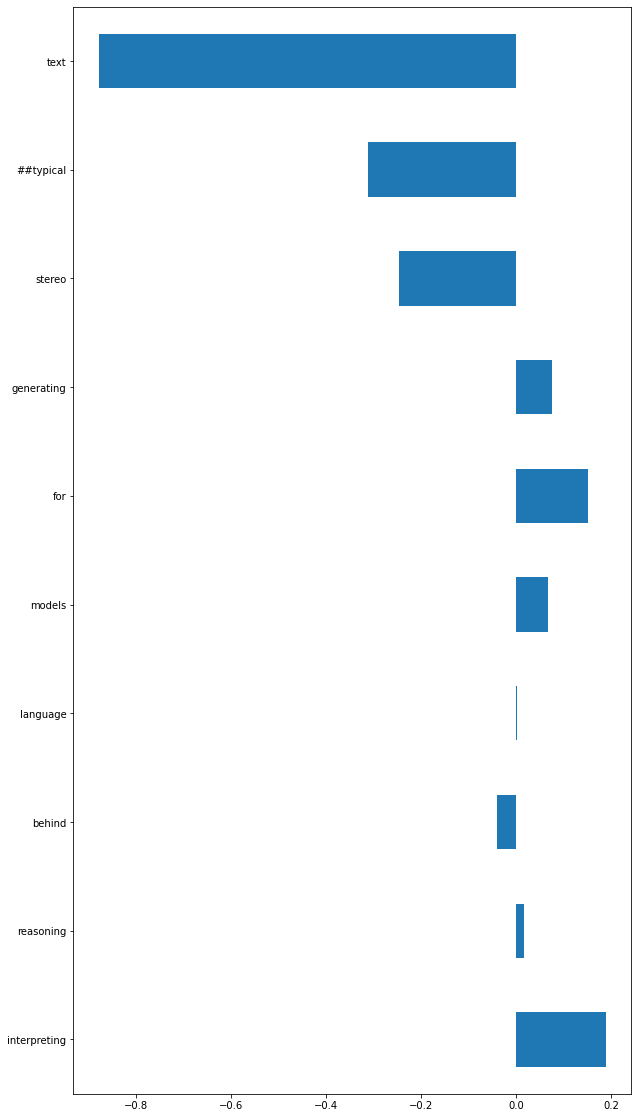

In [8]:
import torch
import pandas as pd

from torch import tensor 
from transformers import DistilBertTokenizer
from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase

import matplotlib.pyplot as plt

class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name:str, pipeline: TextClassificationPipeline, device: str):
        self.__name = name
        self.__pipeline = pipeline
        self.__device = device
    
    def forward_func(self, inputs: tensor, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        pred = self.__pipeline.model(inputs,
                       attention_mask=torch.ones_like(inputs))
        return pred[position]
        
    def visualize(self, inputs: list, attributes: list,prediction:list):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        attr_sum = attributes.sum(-1) 
        
        attr = attr_sum / torch.norm(attr_sum)
        
        a = pd.Series(attr.numpy()[0], 
                         index = self.__pipeline.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]))
        
        plt.show(a.plot.barh(figsize=(10,20)))
                      
    def explain(self, text: str):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        prediction = self.__pipeline(text)
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        
        lig = LayerIntegratedGradients(self.forward_func, getattr(self.__pipeline.model, 'distilbert').embeddings)
        
        attributes, delta = lig.attribute(inputs=inputs,
                                  baselines=baseline,
                                  target = self.__pipeline.model.config.label2id[prediction[0]['label']], 
                                  return_convergence_delta = True)
        
        self.visualize(inputs, attributes, prediction)
        
    def generate_inputs(self, text: str) -> tensor:
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.__pipeline.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len: int) -> tensor:
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.__pipeline.tokenizer.cls_token_id] + [self.__pipeline.tokenizer.pad_token_id] * (sequence_len - 2) + [self.__pipeline.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)

exp_model = ExplainableTransformerPipeline("distilbert", clf,'cpu')
exp_model.explain("Interpreting reasoning behind language models for generating stereotypical text")  